In [1]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

# Useful functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')

def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [3]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [4]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [5]:
IPython.display.Audio('ClocheB.WAV')

In [6]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

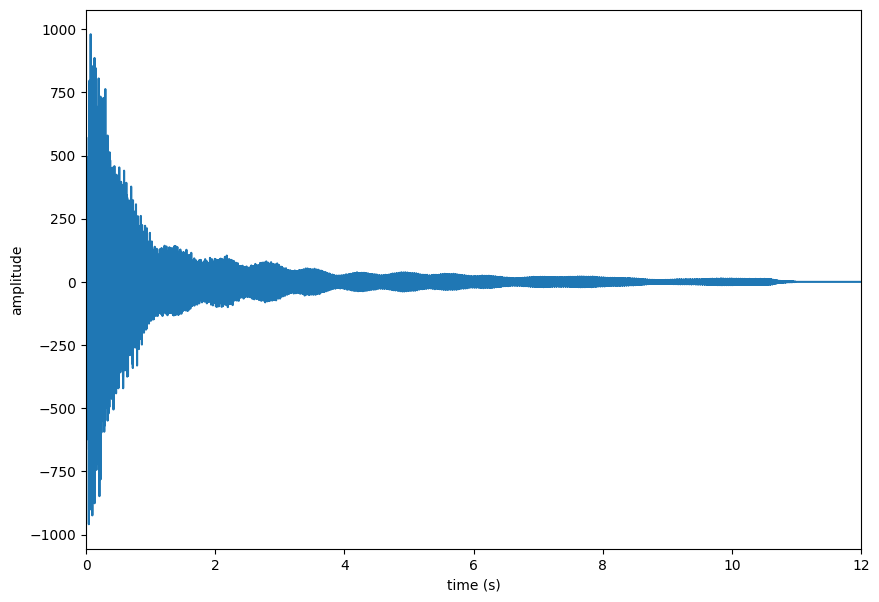

In [7]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [8]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

In [9]:
N = 63
delta = [0,-0.05]
f = [1/4 , 1/4 + 1/N]
f  = np.array(f,dtype=complex)
a  = [1,10]
phi = np.random.uniform(-np.pi,np.pi,2)
x = Synthesis(N,delta,f,a,phi)
print("frequencies: ", f)
print("amplitudes: ", a)
print("phases: ", phi)

frequencies:  [0.25      +0.j 0.26587302+0.j]
amplitudes:  [1, 10]
phases:  [-1.87593913  0.15940126]


### 3.2 High resolution methods
#### 1 . Computation of the empirical covariance matrix

In [10]:
def covariance_matrix(x):
    _ , l = np.shape(x)
    return np.dot(x,x.T)/l

n = 32 
l = N - n + 1
X = hankel(x[:n],x[n-1:len_x])
cov = covariance_matrix(X)
print(np.shape(cov))
U1,D, U2 = np.linalg.svd(cov)
print(np.shape(U1),np.shape(D),np.shape(U2))


(32, 32)
(32, 32) (32,) (32, 32)


For ESPRIT method we first need to compute the eigen signal decomposition of our signal hankel matrix $X = U1 \Lambda U2$.  

Here we will take the first two columns of $U_1$ to make the $W$ matrix.

Then , we compute $W_{\downarrow}$ and $W_{\uparrow}$ the matricies obtained by taking of respectively the last and first rows of the matrix $W$.
We then compute the matrix $\Phi = W_{\downarrow}^{\dagger} W_{\uparrow}$ and its eigen values : $z_1,..., z_n$ the poles of the polynomial we want to estimate.  
Let $\forall k \hspace{0.1cm} \delta_k = \log(|z_k|) , f_k = \frac{\arg(z_k)}{2 \pi}$.
We then return $\delta = [\delta_1,...,\delta_n]$ and $f  = [f_1, ... , f_n]$  

Then with the LeastSquare function, we evaluate $V^N$ the $N \times K$ Vandrmonde matrix such that :$ \ln(V_{t,k}^N) = t(\delta_k +  i 2 \pi f_k)$  
$\alpha = V^{N \dagger} x$ with $ x= [x[0], ... , x[N-1]]$ by computing an argument and a module of each coefficient of alpha we get the estimations of the as and phis we set in the beggining

In [11]:
def ESPRIT(W):

    Wlow = W[:-1, :]
    Wup = W[1:, :]
    
    phi = np.dot(np.linalg.pinv(Wlow),Wup)
    eigen_values = np.linalg.eigvals(phi)
    delta = np.log(np.abs(eigen_values))
    
    f = np.angle(eigen_values)/(2*np.pi)
    return delta, f


def LeastSquares(X,delta,f):
    
    lnV = np.dot(np.arange(X.shape[0]).reshape(1, -1).T, (delta + 1j*2*np.pi*f).reshape(1, -1))
    V = np.exp(lnV)
    A = np.dot(np.linalg.pinv(V),X)
    
    return np.abs(A), np.angle(A)

W = U1[:,:2]
delta,f = ESPRIT(W)
print("delta : " , (delta), "f : " , f)
A,phi = LeastSquares(x[:n],delta,f)
print("alphas:" , A)
print("phases:" , phi)

delta :  [-5.00000000e-02  6.66133815e-16] f :  [0.26587302 0.25      ]
alphas: [10.  1.]
phases: [ 0.15940126 -1.87593913]


We get here the accurate deltas and alphas we put initialy in the signal for estimation which proves the ESPRIT method to be effecient for

### 3.2.2 Music Method
#### 6. Music pseudo-spectrum

For Music method, we also need to compute the eigen signal decomposition of our signal hankel matrix $X = U1 \Lambda U2$.  

Then we the first K columns of $U_1$ will make the $W$ matrix and the others the $W_{\perp}$ matrix.  

After that we just compute $P(z) = \frac{1}{||W_{\perp} v^n(z)||}$ where $v^n(z) = [1,z,..,z^n]$ for a range of complex numbers $z= \exp( \delta + 2 i \pi f)$

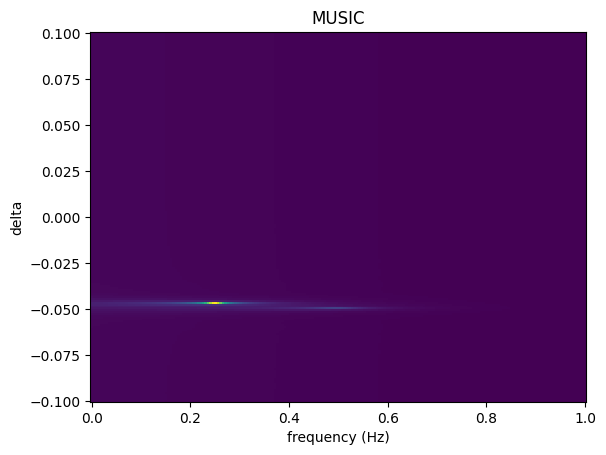

In [12]:
def Music(x,n,K):
    
    X = hankel(x[:n],x[n-1:N])
    cov = covariance_matrix(X)
    U1,D, U2 = np.linalg.svd(cov)
    Wo = U1[:,K:]
    WoH = np.conjugate(Wo.T)
    f = np.linspace(0,1,200)
    delta = np.linspace(-0.1,0.1,200)
    P = np.zeros((len(f),len(delta)))
    for i in range(len(f)):
        for j in range(len(delta)):
            Vn = np.exp(np.matrix(np.arange(n)).T*(delta[j] + 1j*2*np.pi*f[i]))
            P[i,j] = 1/np.linalg.norm(np.dot(WoH, Vn))
              
    
    f, delta = np.meshgrid(f,delta)
    ax = plt.subplot()
    ax.pcolormesh(f,delta,P)
    plt.xlabel('frequency (Hz)')
    plt.ylabel('delta')
    plt.title('MUSIC')
    plt.show()
    return P


P = Music(x,n,2)


Here, we notice that despite the -0.05 frequency has been well detected by the music method,  we still have a little bias.

# 4. Audio signals
## 4.2 Spectral analysis by Fourier transform

Here we take two signals to which we apply ESPRIT method to estimate the poles and get the corresponding PSD.

In [13]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
FsA = int(wavefile.getframerate())
clocheA= np.array(data)
num_samples = int(wavefile.getnframes())
periodogramA = np.abs(np.fft.fft(clocheA))**2


In [14]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheB.WAV')
FsB = int(wavefile.getframerate())
clocheB= np.array(data)
num_samples = int(wavefile.getnframes())
periodogramB = np.abs(np.fft.fft(clocheB))**2



In [15]:
print(np.shape(periodogramA),np.shape(periodogramB))

(1, 95997) (1, 99414)


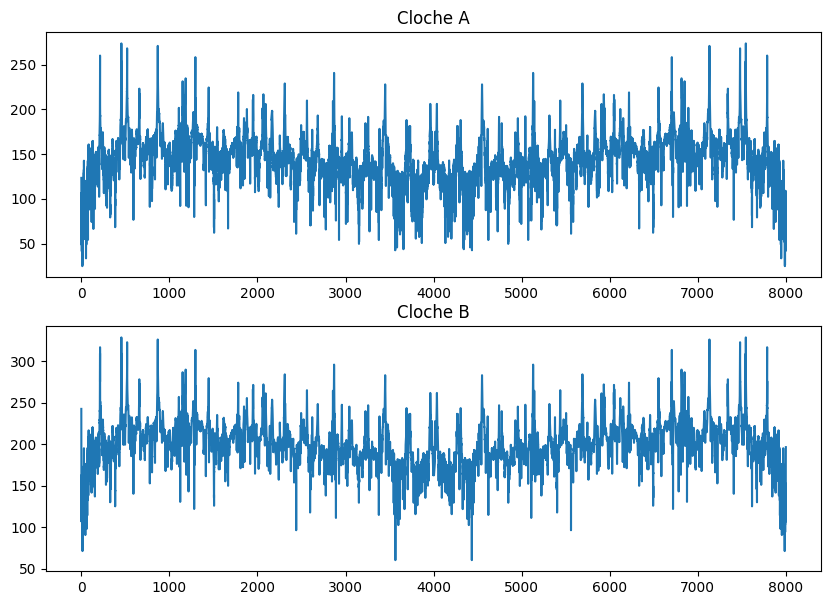

In [16]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(np.linspace(0,FsA,len(clocheA[0,:])),10*np.log(periodogramA[0,:]))
plt.title('Cloche A')
plt.subplot(2,1,2)
plt.plot(np.linspace(0,FsB,len(clocheB[0,:])),10*np.log(periodogramB[0,:]))
plt.title('Cloche B')
plt.show()

32000
(512, 512)
(512, 512) (512,) (512, 512)


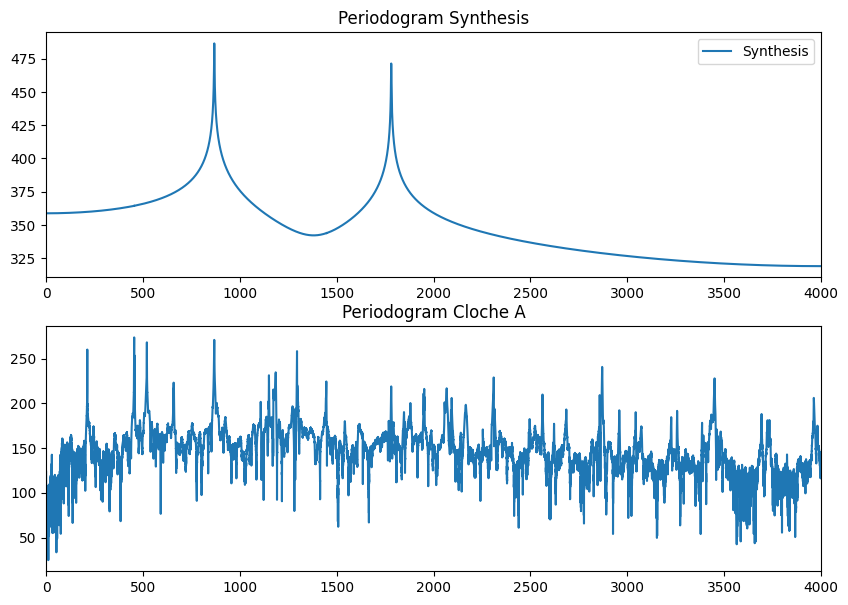

32000 1535


In [ ]:
K = 54
n = 512
l = 1024
N = 4*FsA


sample = clocheA[0,1000:1000+N]
print(N)


X = hankel(sample[:n],sample[n-1:len_x])
cov = covariance_matrix(X)
print(np.shape(cov))
U1,D, U2 = np.linalg.svd(cov)
print(np.shape(U1),np.shape(D),np.shape(U2))
W = U1[:,:K]
delta,f = ESPRIT(W)
A,phi = LeastSquares(sample[:n],delta,f)

synthesis = Synthesis(N, delta, f, np.array(A).flatten(), np.array(phi).flatten())
periodograms = np.abs(np.fft.rfft(np.real(synthesis)))**2
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(np.fft.rfftfreq(N,1/FsA),10*np.log(periodograms),label= "Synthesis")

plt.legend()
plt.title('Periodogram Synthesis')
plt.xlim(0,FsA/2)
plt.subplot(2,1,2)
plt.plot(np.linspace(0,FsA,len(clocheA[0,:])),10*np.log(periodogramA[0,:]), label='Cloche A')
plt.title('Periodogram Cloche A')
plt.xlim(0,FsA/2)

plt.show()
print(len(synthesis),len(sample))
write('clocheAsynth.wav', FsA, np.array(np.real(synthesis), dtype=np.int16)) # to write a new wave file
# 1535 samples for 3 seconds Fs =51200
IPython.display.Audio('clocheAsynth.wav')


Here we get a comparable and distinguishable sound which prooves the method works for cloche A

In [18]:
print(delta)

[-8.04199589e-04 -8.04199589e-04 -2.93384858e-04 -2.93384858e-04
 -1.04533969e-03 -1.04533969e-03 -9.76466715e-04 -9.76466715e-04
 -2.93976733e-04 -2.93976733e-04 -2.59297229e-04 -2.59297229e-04
 -4.77376015e-04 -4.77376015e-04 -2.56364626e-04 -2.56364626e-04
 -1.53404680e-04 -1.53404680e-04 -8.65488689e-04 -8.65488689e-04
 -3.46854487e-04 -3.46854487e-04 -6.94572860e-04 -6.94572860e-04
 -8.88142926e-05 -8.88142926e-05 -1.78710302e-04 -1.78710302e-04
 -4.01608968e-04 -4.01608968e-04 -8.21740319e-04 -8.21740319e-04
 -1.04229233e-04 -1.04229233e-04 -1.12193065e-04 -1.12193065e-04
 -8.60651146e-04 -8.60651146e-04 -5.07798252e-03 -5.07798252e-03
 -5.66032439e-05 -5.66032439e-05  5.36459187e-04  5.36459187e-04
 -3.54300465e-04 -3.54300465e-04 -1.45578178e-03 -1.45578178e-03
 -8.45920991e-05 -8.45920991e-05 -1.36684576e-03 -1.36684576e-03
 -1.48518339e-03 -1.48518339e-03]


In [19]:
print(FsA)

8000


(512, 512)
(512, 512) (512,) (512, 512)


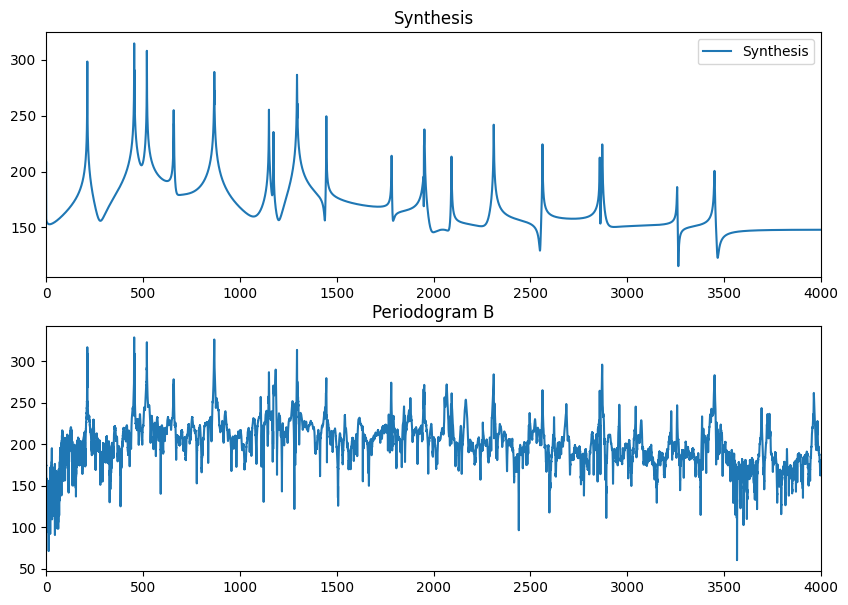

In [20]:
K = 54
n = 512
l = 1024
N = 4*FsB

sample2 = clocheB[0, 10_000 : 10_000+N]


X = hankel(sample2[:n],sample2[n-1:len_x])
cov = covariance_matrix(X)
print(np.shape(cov))
U1,D, U2 = np.linalg.svd(cov)
print(np.shape(U1),np.shape(D),np.shape(U2))
W = U1[:,:K]
delta,f = ESPRIT(W)
A,phi = LeastSquares(sample2[:n],delta,f)

synthesis = Synthesis(N, delta, f, np.array(A).flatten(), np.array(phi).flatten())
periodograms = np.abs(np.fft.rfft(np.real(synthesis)))**2
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(np.fft.rfftfreq(N,1/FsB),10*np.log(periodograms),label= "Synthesis")
plt.xlim(0,FsB/2)
plt.legend()
plt.title('Synthesis')
plt.subplot(2,1,2)
plt.plot(np.linspace(0,FsB,len(clocheB[0,:])),10*np.log(periodogramB[0,:]), label='Cloche B')
plt.title('Periodogram B')
plt.xlim(0,FsB/2)

plt.show()

write('clocheBsynth.wav', FsB, np.array(np.real(synthesis), dtype=np.int16)) # to write a new wave file
IPython.display.Audio('clocheBsynth.wav')


Same results for cloche B despite the little loss on high frequencies